Jugend hackt Einsteiger Workshop
================================

---

> *Ich kann nicht programmieren, ich kann nur ein bisschen python*

Willkommen zum Einsteiger Workshop von Jugend hackt!

In diesem Workshop werdet ihr Grundlagen der Programmierung mit Python 


In [1]:
%matplotlib inline

In [2]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.patches
import matplotlib.collections
import matplotlib.path

import utm
import geojson
import json
import collections

In [3]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

In [4]:
raw = geojson.load(open("data/hamburg.geojson"))

In [5]:
def isStadtteil(f):
    return f['properties'].get('name:prefix') == "Stadtteil"

regions = filter(isStadtteil, raw['features'])

borders = {
    region['properties'].get('name'):
        (region['geometry']['coordinates'][0], )
        if region['geometry']['type'] == 'Polygon'
    else tuple(map(lambda p: p[0], region['geometry']['coordinates']))
    for region in regions if all([
        region['properties'].get('name'),
        region['geometry']['type'] in ['Polygon', 'MultiPolygon'],
    ])
}

outlines = {
    name: tuple(
        (
            [lon for lon, lat in polygon],
            [lat for lon, lat in polygon]
        ) for polygon in polygons
    ) for name, polygons in borders.iteritems()
}

In [10]:
def NoneIsZero(value):
    return 0 if value is None else value

raw_data = json.load(open("data/schulen.geojson"))
schools = [
    {
        'name': feature['properties'].get('Name'),
        'region': feature['properties'].get('stadtteil'),
        'position': utm.to_latlon(feature['geometry']['coordinates'][0],
                                  feature['geometry']['coordinates'][1],
                                  32, 'N'),
        'value': NoneIsZero(feature['properties'].get('schueleranzahl')),
    } for feature in raw_data['features']
]
data = schools

def count_by_region(regions, data, key=None):
    count = collections.defaultdict(int)
    for entry in data:
        count[entry['region']] += int(entry.get(key, 1))
    return count

# count = count_by_region(borders, data, key="value")
count = count_by_region(borders, data)

In [11]:
raw_data = json.load(open("data/gruenflaechen.geojson"))
gruenflaechen = [
    {
        'name': feature['properties'].get('Name'),
        'region': feature['properties'].get('stadtteil'),
        'position': utm.to_latlon(feature['geometry']['coordinates'][0],
                                  feature['geometry']['coordinates'][1],
                                  32, 'N'),
    } for feature in raw_data['features']
]
data = schools

def count_by_position(regions, data, key=None):
    paths = {
        name: matplotlib.path.Path(
            np.array(polygon),
            ([matplotlib.path.Path.MOVETO] +
             [matplotlib.path.Path.LINETO for _ in range(len(polygon) - 2)] +
             [matplotlib.path.Path.CLOSEPOLY]
             )
        )
        for name, polygons in regions.iteritems()
        for polygon in polygons
    }
    count = collections.defaultdict(int)
    for entry in data:
        for name, path in paths.iteritems():
            pos = entry['position'][1], entry['position'][0]
            if path.contains_point(pos):
                count[name] += int(entry.get(key, 1))
    return count
count = count_by_position(borders, data)

In [12]:
positions = zip(*[entry['position'] for entry in data])
values = [float(entry['value']) / 10 for entry in data]
# values = 10

In [8]:
normalize = matplotlib.colors.Normalize(vmin=min(count.values()), vmax=max(count.values()))
colors = matplotlib.cm.get_cmap('Spectral')

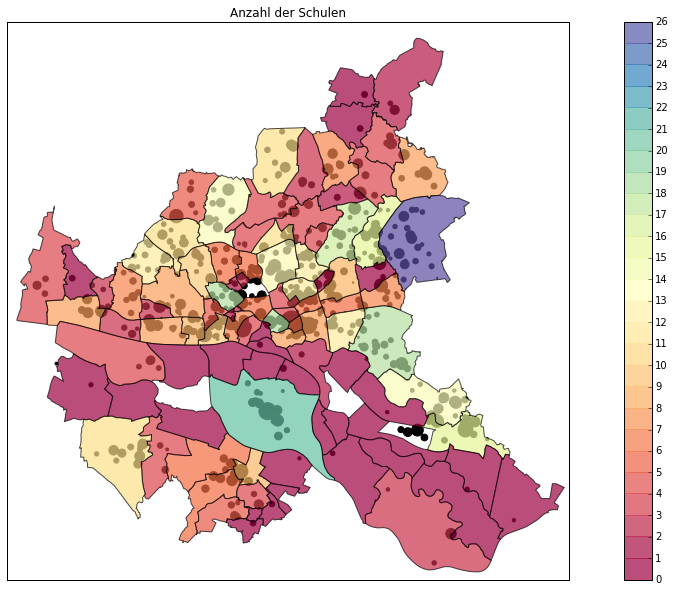

In [13]:
corners = (
    (53.39, 9.72), (53.75, 10.33)
)

m = Basemap(projection='merc',
            urcrnrlat=corners[1][0], urcrnrlon=corners[1][1],
            llcrnrlat=corners[0][0], llcrnrlon=corners[0][1],
            lat_0=53.5449, lon_0=9.9731,
            resolution='h')
ax = plt.gca()

patches = []
counts = []
for name, polygons in outlines.iteritems():
    for (lons, lats) in polygons:
        x, y = m(lons, lats)
        xy = zip(x, y)
        patches.append(matplotlib.patches.Polygon(xy))
        counts.append(count[name])
        
x, y = m(positions[1], positions[0])
plt.scatter(x, y, values, "k")

m.set_axes_limits()

p = matplotlib.collections.PatchCollection(patches, cmap=colors, norm=normalize, alpha=0.7)
p.set_array(np.array(counts))
ax.add_collection(p)
plt.colorbar(p,
             spacing="proportional",
             ticks=range(max(counts) + 1),
             boundaries=range(max(counts) + 1))


plt.title("Anzahl der Schulen")
# plt.title(u"Anzahl der Grünflächen")